<div class='alert alert-block alert-warning'>
In this notebook, I use the Python API v1 library to access NCBI Datasets. Do note that this v1 API will be retired from <b>Dec 2024<b/>.
<div/>

First, we need to import the relevant modules and functions. 
I am also configuring some parameters that will be used throughout this notebook.

In [ ]:
# importing relevant modules
import os
import shutil
from pathlib import Path

import pandas as pd

import ncbi.datasets.openapi
import ncbi.datasets.openapi.exceptions as ncbiExceptions
from ncbi.datasets.openapi.api import genome_api
from ncbi.datasets.openapi.model.v1_annotation_for_assembly_type import V1AnnotationForAssemblyType
from ncbi.datasets.openapi.model.v1_assembly_dataset_request_resolution import V1AssemblyDatasetRequestResolution
from ncbi.datasets.openapi.model.v1_assembly_dataset_request import V1AssemblyDatasetRequest

### defining the host url and my api key
# Defining the host is optional and defaults to https://api.ncbi.nlm.nih.gov/datasets/v1
# See configuration.py for a list of all supported configuration parameters.
configuration = ncbi.datasets.openapi.Configuration(
    host="https://api.ncbi.nlm.nih.gov/datasets/v1"
)

# Configure API key authorization: ApiKeyAuthHeader
configuration.api_key['ApiKeyAuthHeader'] = 'INSERT_API_TOKEN_HERE' # for security reasons, you should store your API token in an environment variable

# setting the cell output display (this is something I do across all my notebooks)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


## 1. Obtaining a list of all *Vibrionaceae* species with available genomes in NCBI

### 1.1. Visit [NCBI genome datasets](https://www.ncbi.nlm.nih.gov/datasets/genome/)
### 1.2. Key in `Vibrionaceae` as the search term and filter the search results `From type material`

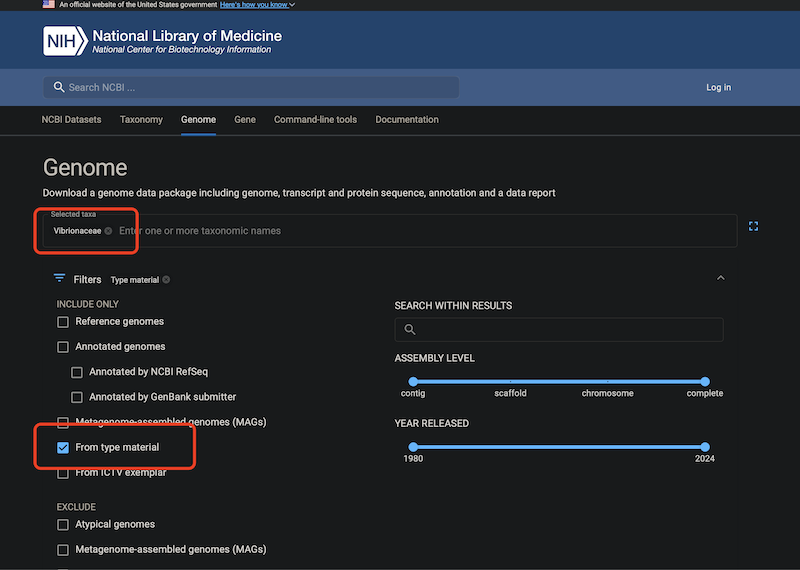

### 1.3. Then click `Select columns` and check the following parameters:
* `CheckM completeness (%)`
* `CheckM contamination (%)`

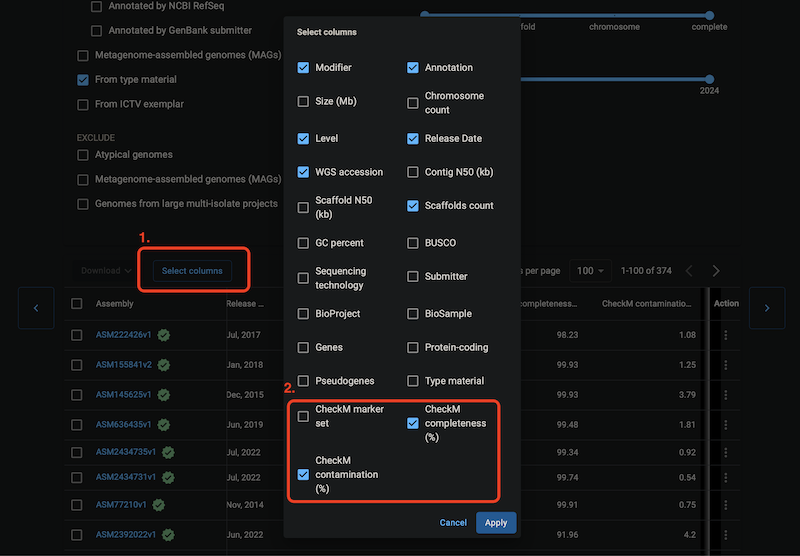

### 1.4. I then select all rows and download the metadata table in `tsv` format

---

## 2. Filtering the metadata to keep genome accessions with:
* `CheckM completeness >= 90%`
* `CheckM contamination <= 5%` (note that we change this to `6%` later on)

<a id="section-2"></a>

### 2.1. Import the metadata table and inspect the data

In [88]:
df = pd.read_csv("01_data/03_metadata/vibrionaceae_metadata.tsv", sep="\t")
display(len(df))
df.head()

712

,Assembly Accession,Assembly Name,Organism Name,Organism Taxonomic ID,Organism Infraspecific Names Breed,Organism Infraspecific Names Strain,Organism Infraspecific Names Cultivar,Organism Infraspecific Names Ecotype,Organism Infraspecific Names Isolate,Organism Infraspecific Names Sex,Annotation Name,Assembly Stats Total Sequence Length,Assembly Level,Assembly Release Date,WGS project accession,Assembly Stats Contig N50,Assembly Stats Scaffold N50,Assembly Stats Number of Scaffolds,Assembly Sequencing Tech,CheckM completeness,CheckM contamination
0,GCA_002224265.1,ASM222426v1,Vibrio vulnificus NBRC 15645 = ATCC 27562,1219061,NaN,ATCC 27562,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,5007160,Complete Genome,2017-07-24,NaN,3266118,3266118.0,2.0,PacBio; Illumina,98.23,1.08
1,GCF_002224265.1,ASM222426v1,Vibrio vulnificus NBRC 15645 = ATCC 27562,1219061,NaN,ATCC 27562,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,5007160,Complete Genome,2017-07-24,NaN,3266118,3266118.0,2.0,PacBio; Illumina,98.23,1.08
2,GCA_001558415.2,ASM155841v2,Vibrio fluvialis,676,NaN,ATCC 33809,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,4827733,Complete Genome,2018-01-29,NaN,3155838,3155838.0,2.0,PacBio; Illumina,99.93,1.25
3,GCF_001558415.2,ASM155841v2,Vibrio fluvialis,676,NaN,ATCC 33809,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,4827733,Complete Genome,2018-01-29,NaN,3155838,3155838.0,2.0,PacBio; Illumina,99.93,1.25
4,GCA_001456255.1,ASM145625v1,Vibrio natriegens NBRC 15636 = ATCC 14048 = DS...,1219067,NaN,ATCC 14048,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,5175153,Complete Genome,2015-12-03,NaN,3248023,3248023.0,2.0,PacBio,99.93,3.79


Here, we are taking a quick look at the mean and spread of the data using a five-point summary

In [20]:
completeness = df["CheckM completeness"]
contam = df["CheckM contamination"]

display(completeness.describe())
display(contam.describe())

count    711.000000
mean      95.106385
std        7.505458
min       10.990000
25%       93.485000
50%       97.250000
75%       99.395000
max      100.000000
Name: CheckM completeness, dtype: float64

count    707.000000
mean       2.045926
std        1.882902
min        0.030000
25%        0.730000
50%        1.450000
75%        2.840000
max       11.620000
Name: CheckM contamination, dtype: float64

### 2.2. Filtering the dataframe according to the conditions listed in [Section 2](#section-2)

In [16]:
# filtering the dataframe to keep rows where completeness is >= 90% and contamination is <= 5%
df90_5 = df[(df["CheckM completeness"]>=90) & (df["CheckM contamination"]<=5)]

# checking that dataframe is filtered correctly
print(df90_5["CheckM completeness"].min())
print(df90_5["CheckM contamination"].max())

90.1
4.85


Indeed, from the above cell output, the dataframe has been filtered correctly according to our specified conditions. <br/>
However, after inspecting the filtered dataframe, I realised that some genomes that have contamination marginally above 5% are excluded. <br/> 
Increasing the contamination threshold to 6% allows me to include 6 more genomes + **2 type species** (from *Aliivibrio* and *Enterovibrio*)
> This will provide me with a more comprehensive dataset for genomic and phylogenetic analyses downstream

<div class='alert alert-block alert-info'>
New CheckM filter condition is now: 
<br/>
<b>&#8226; completeness >= 90%</b>
<br/>
<b>&#8226; contamination <= 6%</b>
</div>

#### Here, we will filter the dataframe based on the newly adjusted conditions

In [87]:
# >=90% completeness, <=6% contamination
df90_6 = df[(df["CheckM completeness"]>=90) & (df["CheckM contamination"]<=6)]
df90_6_derep = df90_6.drop_duplicates("Assembly Name", keep="last") # to keep only GCF assemblies if possible

def parser(col_org_name):
    return ' '.join(col_org_name.split(' ')[:2])

df90_6_derep.loc[:, 'Organism Name'] = df90_6_derep.apply(lambda x: parser(x['Organism Name']), axis=1) # parsing 'Organism Name' of NCBI dataframe to retain only species name

### Renaming some taxa to follow LPSN convention ###
df90_6_derep.loc[df90_6_derep['Organism Name']=='Grimontia celer', 'Organism Name'] = 'Grimontia celeris'
df90_6_derep.loc[df90_6_derep['Organism Name']=='Vibrio anguillarum', 'Organism Name'] = 'Listonella anguillarum'
df90_6_derep.loc[df90_6_derep['Organism Name']=='Vibrio pelagius', 'Organism Name'] = 'Listonella pelagia'

df90_6_derep = df90_6_derep.drop_duplicates("Organism Name", keep="first") # dereplicate 'Organism Name'
df90_6_derep.sort_values("Organism Name", inplace=True)
display(len(df90_6_derep))
df90_6_derep.head()

187

,Assembly Accession,Assembly Name,Organism Name,Organism Taxonomic ID,Organism Infraspecific Names Breed,Organism Infraspecific Names Strain,Organism Infraspecific Names Cultivar,Organism Infraspecific Names Ecotype,Organism Infraspecific Names Isolate,Organism Infraspecific Names Sex,Annotation Name,Assembly Stats Total Sequence Length,Assembly Level,Assembly Release Date,WGS project accession,Assembly Stats Contig N50,Assembly Stats Scaffold N50,Assembly Stats Number of Scaffolds,Assembly Sequencing Tech,CheckM completeness,CheckM contamination
615,GCF_008933155.1,ASM893315v1,Aliivibrio finisterrensis,511998,NaN,LMG 23869,NaN,NaN,NaN,NaN,GCF_008933155.1-RS_2024_04_23,3916971,Contig,2019-10-09,WBVP01,168183,NaN,NaN,NovaSeq 6000,99.66,0.04
447,GCF_014647395.1,ASM1464739v1,Aliivibrio fischeri,668,NaN,JCM 18803,NaN,NaN,NaN,NaN,GCF_014647395.1-RS_2024_09_03,4289740,Scaffold,2020-09-12,BMPC01,44068,72515.0,167.0,Illumina HiSeq X Ten,92.32,5.60
171,GCF_002954715.1,ASM295471v1,Aliivibrio sifiae,566293,NaN,NBRC 105001,NaN,NaN,NaN,NaN,GCF_002954715.1-RS_2024_05_03,4743237,Scaffold,2018-02-27,MSCP01,235907,2522736.0,8.0,Illumina MiSeq,99.63,0.48
169,GCF_004120195.1,ASM412019v1,Enterovibrio baiacu,2491023,NaN,A649,NaN,NaN,NaN,NaN,GCF_004120195.1-RS_2024_03_28,5371326,Contig,2019-01-30,SCHN01,283124,NaN,NaN,Illumina MiSeq,91.81,4.85
155,GCF_000621165.1,ASM62116v1,Enterovibrio calviensis,1121867,NaN,DSM 14347,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,5503346,Scaffold,2014-04-08,JHZA01,323395,461029.0,28.0,Illumina HiSeq 2000,98.89,1.34


---

## 3. Validating our NCBI metadata dataset

### 3.1. Downloading LPSN metadata
Now that we have prepared our NCBI dataset metadata, we need to validate this dataset, ie., including only validly published strains/genomes. <br/> We do this by first downloading the complete list of validly published prokaryotes from [LPSN](https://bacterio.net), and then validating our dataset against this list later

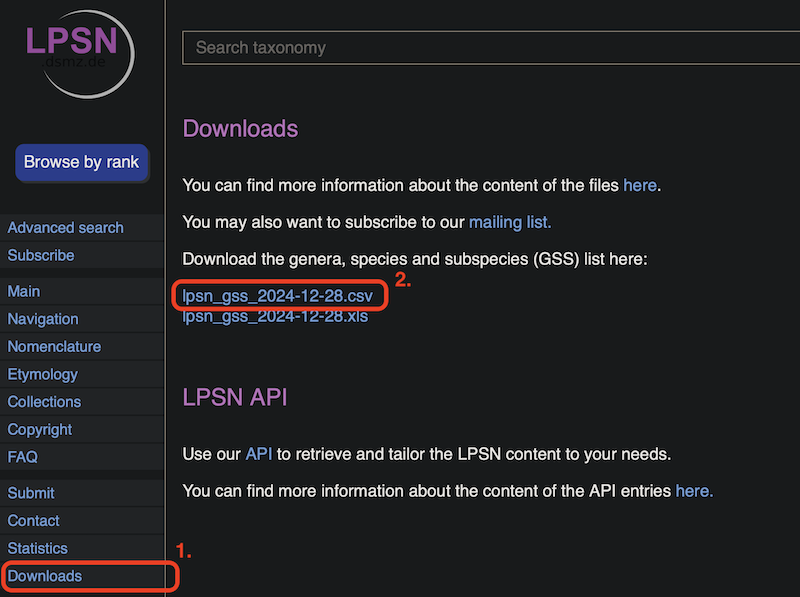

In [30]:
# inspecting the data
lpsn_md = pd.read_csv("01_data/03_metadata/lpsn_gss_2024-09-24.csv") # depending on when you download the data, the file name will be different
lpsn_md.head()

,genus_name,sp_epithet,subsp_epithet,reference,status,authors,address,risk_grp,nomenclatural_type,record_no,record_lnk
0,Abditibacterium,utsteinense,NaN,"Oren A, Garrity GM. Validation list no. 184. L...",VL; sp. nov.; validly published under the ICNP...,Tahon et al. 2018,https://lpsn.dsmz.de/species/abditibacterium-u...,NaN,DSM 105287; LMG 29911; R-68213,797965,NaN
1,Abditibacterium,NaN,NaN,"Oren A, Garrity GM. Validation list no. 184. L...",VL; gen. nov.; validly published under the ICN...,Tahon et al. 2018,https://lpsn.dsmz.de/genus/abditibacterium,NaN,797965,520424,NaN
2,Abiotrophia,adiacens,NaN,"Kawamura Y, Hou XG, Sultana F, Liu S, Yamamoto...",VP; comb. nov.; validly published under the IC...,(Bouvet et al. 1989) Kawamura et al. 1995,https://lpsn.dsmz.de/species/abiotrophia-adiacens,2.0,ATCC 49175; CCUG 27637; CCUG 27637 A; CCUG 278...,772466,776611.0
3,Abiotrophia,balaenopterae,NaN,"Lawson PA, Foster G, Falsen E, Sjoden B, Colli...",VP; sp. nov.; validly published under the ICNP...,Lawson et al. 1999,https://lpsn.dsmz.de/species/abiotrophia-balae...,2.0,ATCC 700813; CCUG 37380; CIP 105938; DSM 15827...,772467,776612.0
4,Abiotrophia,defectiva,NaN,"Kawamura Y, Hou XG, Sultana F, Liu S, Yamamoto...",VP; comb. nov.; validly published under the IC...,(Bouvet et al. 1989) Kawamura et al. 1995,https://lpsn.dsmz.de/species/abiotrophia-defec...,2.0,ATCC 49176; CCUG 27639; CCUG 27804; CIP 103.24...,772468,NaN


In [77]:
# filter validly published taxa only
lpsn_md_valid = lpsn_md[lpsn_md['status'].str.contains('correct name')]
# create new column for species name
lpsn_md_valid.loc[:, 'species'] = lpsn_md_valid['genus_name'] + ' ' + lpsn_md_valid['sp_epithet']

display(len(lpsn_md_valid))
lpsn_md_valid.head()

24620

,genus_name,sp_epithet,subsp_epithet,reference,status,authors,address,risk_grp,nomenclatural_type,record_no,record_lnk,species
0,Abditibacterium,utsteinense,NaN,"Oren A, Garrity GM. Validation list no. 184. L...",VL; sp. nov.; validly published under the ICNP...,Tahon et al. 2018,https://lpsn.dsmz.de/species/abditibacterium-u...,NaN,DSM 105287; LMG 29911; R-68213,797965,NaN,Abditibacterium utsteinense
1,Abditibacterium,NaN,NaN,"Oren A, Garrity GM. Validation list no. 184. L...",VL; gen. nov.; validly published under the ICN...,Tahon et al. 2018,https://lpsn.dsmz.de/genus/abditibacterium,NaN,797965,520424,NaN,NaN
4,Abiotrophia,defectiva,NaN,"Kawamura Y, Hou XG, Sultana F, Liu S, Yamamoto...",VP; comb. nov.; validly published under the IC...,(Bouvet et al. 1989) Kawamura et al. 1995,https://lpsn.dsmz.de/species/abiotrophia-defec...,2.0,ATCC 49176; CCUG 27639; CCUG 27804; CIP 103.24...,772468,NaN,Abiotrophia defectiva
6,Abiotrophia,NaN,NaN,"Kawamura Y, Hou XG, Sultana F, Liu S, Yamamoto...",VP; gen. nov.; validly published under the ICN...,Kawamura et al. 1995,https://lpsn.dsmz.de/genus/abiotrophia,2.0,772468,514986,NaN,NaN
7,Absicoccus,porci,NaN,"Shin Y, Paek J, Kim H, Kook JK, Kim JS, Kim SH...",VP; sp. nov.; validly published under the ICNP...,Shin et al. 2020,https://lpsn.dsmz.de/species/absicoccus-porci,NaN,JCM 32769; KCTC 15747; YH-panp20,5758,NaN,Absicoccus porci


### 3.2. Filtering only validly published names from *Vibrionaceae* in the LPSN metadata

After downloading the complete metadata from LPSN, we now need to filter the data.

#### 3.2.1. Identify valid genera of interest from LPSN website
Firstly, we would like to filter only *Vibrionaceae*. However, as we can see from the LPSN metadata above, it only contains columns for the genus and species but not the family. Hence, we need to manually visit the [LPSN site](https://bacterio.net) to identify the genera that we are interested in.

In [33]:
# note Echinimonas and Neiella are proposed to belong to a new family "Echinimonadaceae", but i didnt include them as the new family is still not validly published
valid_genera = [
    'Aliivibrio',
    'Catenococcus',
    # 'Echinimonas',
    'Enterovibrio',
    'Grimontia',
    'Listonella',
    # 'Neiella',
    'Paraphotobacterium',
    'Photobacterium',
    'Salinivibrio',
    'Thaumasiovibrio',
    'Veronia',
    'Vibrio',
]
# converting the list to a dataframe
valid_genera_df = pd.DataFrame({'genus_name': valid_genera})
valid_genera_df

,genus_name
0,Aliivibrio
1,Catenococcus
2,Enterovibrio
3,Grimontia
4,Listonella
5,Paraphotobacterium
6,Photobacterium
7,Salinivibrio
8,Thaumasiovibrio
9,Veronia


#### 3.2.2. Shortlist *Vibrionaceae* species in LPSN data based on above-defined valid genera

In [78]:
# filtering out non-type subspecies (eg. Photobacterium damselae subsp. piscicida)
lpsn_md_valid = lpsn_md_valid[lpsn_md_valid['subsp_epithet'].isna()]

# filtering LPSN metadata to include only our genera of interest
valid_vibrionaceae = lpsn_md_valid.merge(valid_genera_df, on='genus_name', how='inner')
valid_vibrionaceae = valid_vibrionaceae[~valid_vibrionaceae['sp_epithet'].isna()] # removing rows where sp_epithet is NaN
display(len(valid_vibrionaceae))
valid_vibrionaceae.head()

220

,genus_name,sp_epithet,subsp_epithet,reference,status,authors,address,risk_grp,nomenclatural_type,record_no,record_lnk,species
0,Aliivibrio,finisterrensis,NaN,"Beaz-Hidalgo R, Doce A, Balboa S, Barja JL, Ro...",VP; sp. nov.; validly published under the ICNP...,Beaz-Hidalgo et al. 2010,https://lpsn.dsmz.de/species/aliivibrio-finist...,1.0,CECT 7228; CMJ 11.1; DSM 23419; LMG 23869,788305,NaN,Aliivibrio finisterrensis
1,Aliivibrio,fischeri,NaN,"Urbanczyk H, Ast JC, Higgins MJ, Carson J, Dun...",VP; comb. nov.; validly published under the IC...,(Beijerinck 1889) Urbanczyk et al. 2007,https://lpsn.dsmz.de/species/aliivibrio-fischeri,1.0,398; ATCC 774; ATCC 7744; CAIM 329; CCUG 13450...,787009,NaN,Aliivibrio fischeri
2,Aliivibrio,logei,NaN,"Urbanczyk H, Ast JC, Higgins MJ, Carson J, Dun...",VP; comb. nov.; validly published under the IC...,(Harwood et al. 1980 ex Bang et al. 1978) Urba...,https://lpsn.dsmz.de/species/aliivibrio-logei,1.0,584; ATCC 29985; CCUG 20283; CIP 104991; DSM 2...,787013,NaN,Aliivibrio logei
3,Aliivibrio,salmonicida,NaN,"Urbanczyk H, Ast JC, Higgins MJ, Carson J, Dun...",VP; comb. nov.; validly published under the IC...,(Egidius et al. 1986) Urbanczyk et al. 2007,https://lpsn.dsmz.de/species/aliivibrio-salmon...,1.0,ATCC 43839; CIP 103166; DSM 21110; HI 7751; LM...,787017,NaN,Aliivibrio salmonicida
4,Aliivibrio,sifiae,NaN,Euzeby JP. Validation list no. 139. List of ne...,VL; sp. nov.; validly published under the ICNP...,Yoshizawa et al. 2011,https://lpsn.dsmz.de/species/aliivibrio-sifiae,1.0,DSM 26449; H1-1; KCTC 22535; NBRC 105001,789102,NaN,Aliivibrio sifiae


### 3.3. Validating our NCBI dataset against the filtered LPSN data

After preparing our NCBI and LPSN datasets, we will now check our NCBI dataset against the LPSN dataset to identify genomes that are validly published. <br/>
For genomes that are present in the LPSN dataset but not found in NCBI, we will download these genomes from other database sources.

#### 3.3.1. Filtering NCBI dataset to include only validly published names

In [80]:
# filtering the NCBI dataframe for validly published data
# this is just to check which genomes are already present in the NCBI database
merged_lpsn_ncbi_df = df90_6_derep.merge(valid_vibrionaceae, left_on='Organism Name', right_on='species', how='inner')

display(len(merged_lpsn_ncbi_df))
merged_lpsn_ncbi_df.head()

170

,Assembly Accession,Assembly Name,Organism Name,Organism Taxonomic ID,Organism Infraspecific Names Breed,Organism Infraspecific Names Strain,Organism Infraspecific Names Cultivar,Organism Infraspecific Names Ecotype,Organism Infraspecific Names Isolate,Organism Infraspecific Names Sex,Annotation Name,Assembly Stats Total Sequence Length,Assembly Level,Assembly Release Date,WGS project accession,Assembly Stats Contig N50,Assembly Stats Scaffold N50,Assembly Stats Number of Scaffolds,Assembly Sequencing Tech,CheckM completeness,CheckM contamination,genus_name,sp_epithet,subsp_epithet,reference,status,authors,address,risk_grp,nomenclatural_type,record_no,record_lnk,species
0,GCF_008933155.1,ASM893315v1,Aliivibrio finisterrensis,511998,NaN,LMG 23869,NaN,NaN,NaN,NaN,GCF_008933155.1-RS_2024_04_23,3916971,Contig,2019-10-09,WBVP01,168183,NaN,NaN,NovaSeq 6000,99.66,0.04,Aliivibrio,finisterrensis,NaN,"Beaz-Hidalgo R, Doce A, Balboa S, Barja JL, Ro...",VP; sp. nov.; validly published under the ICNP...,Beaz-Hidalgo et al. 2010,https://lpsn.dsmz.de/species/aliivibrio-finist...,1.0,CECT 7228; CMJ 11.1; DSM 23419; LMG 23869,788305,NaN,Aliivibrio finisterrensis
1,GCF_014647395.1,ASM1464739v1,Aliivibrio fischeri,668,NaN,JCM 18803,NaN,NaN,NaN,NaN,GCF_014647395.1-RS_2024_09_03,4289740,Scaffold,2020-09-12,BMPC01,44068,72515.0,167.0,Illumina HiSeq X Ten,92.32,5.60,Aliivibrio,fischeri,NaN,"Urbanczyk H, Ast JC, Higgins MJ, Carson J, Dun...",VP; comb. nov.; validly published under the IC...,(Beijerinck 1889) Urbanczyk et al. 2007,https://lpsn.dsmz.de/species/aliivibrio-fischeri,1.0,398; ATCC 774; ATCC 7744; CAIM 329; CCUG 13450...,787009,NaN,Aliivibrio fischeri
2,GCF_002954715.1,ASM295471v1,Aliivibrio sifiae,566293,NaN,NBRC 105001,NaN,NaN,NaN,NaN,GCF_002954715.1-RS_2024_05_03,4743237,Scaffold,2018-02-27,MSCP01,235907,2522736.0,8.0,Illumina MiSeq,99.63,0.48,Aliivibrio,sifiae,NaN,Euzeby JP. Validation list no. 139. List of ne...,VL; sp. nov.; validly published under the ICNP...,Yoshizawa et al. 2011,https://lpsn.dsmz.de/species/aliivibrio-sifiae,1.0,DSM 26449; H1-1; KCTC 22535; NBRC 105001,789102,NaN,Aliivibrio sifiae
3,GCF_000621165.1,ASM62116v1,Enterovibrio calviensis,1121867,NaN,DSM 14347,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,5503346,Scaffold,2014-04-08,JHZA01,323395,461029.0,28.0,Illumina HiSeq 2000,98.89,1.34,Enterovibrio,calviensis,NaN,"Pascual J, Macian MC, Arahal DR, Garay E, Puja...",VP; comb. nov.; validly published under the IC...,(Denner et al. 2002) Pascual et al. 2009,https://lpsn.dsmz.de/species/enterovibrio-calv...,1.0,ATCC BAA-606; CCUG 48319; CCUG 48319 B; CECT 7...,787768,NaN,Enterovibrio calviensis
4,GCF_900115495.1,IMG-taxon 2599185265 annotated assembly,Enterovibrio norvegicus,1121869,NaN,DSM 15893,NaN,NaN,NaN,NaN,GCF_900115495.1-RS_2024_04_24,5449689,Scaffold,2016-11-02,FOWR01,88411,117006.0,99.0,NaN,92.02,5.88,Enterovibrio,norvegicus,NaN,"Thompson FL, Hoste B, Thompson CC, Goris J, Go...",VP; sp. nov.; validly published under the ICNP...,Thompson et al. 2002,https://lpsn.dsmz.de/species/enterovibrio-norv...,1.0,CAIM 430; CCUG 47417; DSM 15893; LMG 19839,775989,NaN,Enterovibrio norvegicus


#### 3.3.2. Identifying validly published names in the LPSN dataset that are not present in NCBI
For genomes that are not found in our NCBI metadata dataset, it means that the NCBI genome database does not contain these genomes. <br/>
As such, we will need to attempt to locate them elsewhere.
> For convenience sake and to streamline the analysis, I will only download the genomes for the less represented genera (eg. *Enterovibrio*, *Thaumasiovibrio*, *Veronia* etc.). Genera like *Photobacterium* and *Vibrio* are already well represented

In [42]:
# checking for names in LPSN that are not in NCBI = will need to download these 
lpsn_list = set(valid_vibrionaceae['species'].to_list())
ncbi_list = set(df90_6_derep['Organism Name'].to_list())
to_download = sorted(list(lpsn_list - (lpsn_list&ncbi_list)))
display(len(to_download))
to_download

50

['Aliivibrio logei',
 'Aliivibrio salmonicida',
 'Aliivibrio wodanis',
 'Catenococcus thiocycli',
 'Enterovibrio coralii',
 'Enterovibrio nigricans',
 'Enterovibrio paralichthyis',
 'Paraphotobacterium marinum',
 'Photobacterium aestuarii',
 'Photobacterium alginatilyticum',
 'Photobacterium aplysiae',
 'Photobacterium arenosum',
 'Photobacterium chitinilyticum',
 'Photobacterium galatheae',
 'Photobacterium obscurum',
 'Photobacterium panuliri',
 'Photobacterium profundum',
 'Photobacterium proteolyticum',
 'Photobacterium salinisoli',
 'Salinivibrio proteolyticus',
 'Salinivibrio socompensis',
 'Thaumasiovibrio occultus',
 'Veronia nyctiphanis',
 'Vibrio aerogenes',
 'Vibrio aestivus',
 'Vibrio algarum',
 'Vibrio areninigrae',
 'Vibrio astriarenae',
 'Vibrio cidicii',
 'Vibrio crosai',
 'Vibrio hannami',
 'Vibrio hispanicus',
 'Vibrio madracius',
 'Vibrio maritimus',
 'Vibrio metoecus',
 'Vibrio mexicanus',
 'Vibrio mytili',
 'Vibrio neptunius',
 'Vibrio oceanisediminis',
 'Vibrio ol


#### After sieving through other genomes databases, I have only managed to identify **2 genomes (*E.coralii* and *E.nigricans*)** that passed the CheckM conditions (see [Section 2](#section_2))

I did this by searching for the organism in [BacDive](https://bacdive.dsmz.de) and looking for available accession numbers. 



---

## 4. Downloading genomes from NCBI database

Using the `download_assembly_package` function define below, we download the genomes from NCBI using the 'Assembly Accession' column

<div class='alert alert-block alert-info'>
<b>Date Downloaded:</b> 1st October 2024
</div>

In [ ]:

def download_assembly_package(in_file, out_file: str, input_type="file"):
    '''
    Download genome assemblies by specifying accession numbers and outputs a zipfile containing all requested assemblies

    :param input_type: takes ['file', 'list'] containing accession numbers separate by newline character
    :param in_file: text file containing accession numbers only
    :param out_file: outputs a zip file containing all requested datasets
    :return:
    '''
    with ncbi.datasets.openapi.ApiClient(configuration) as api_client:
        # Create an instance of the API class
        api_instance = genome_api.GenomeApi(api_client)

        #   if input_type is a File, reads the file and writes the accession numbers to a list
        if input_type.lower() == "file":
            with open(in_file, "r") as f:
                accessions = [line.strip("\n") for line in f.readlines() if "nil" not in line]
        elif input_type == "list":
            accessions = in_file
        exclude_sequence = False  # bool | Set to true to omit the genomic sequence. (optional) if omitted the server will use the default value of False
        # modify annotation type as needed (I typically want just the genbank and protein files; the genomic.fna file is included by default)
        include_annotation_type = [
            V1AnnotationForAssemblyType("PROT_FASTA"),
            V1AnnotationForAssemblyType("GENOME_GFF"),
            V1AnnotationForAssemblyType("GENOME_GB"),
        ]  # [V1AnnotationForAssemblyType] | Select additional types of annotation to include in the data package.  If unset, no annotation is provided. (optional)
        hydrated = V1AssemblyDatasetRequestResolution(
            "FULLY_HYDRATED")  # V1AssemblyDatasetRequestResolution | Set to DATA_REPORT_ONLY, to only retrieve data-reports. (optional)
        try:
            # Check the validity of genome accessions
            api_response = api_instance.check_assembly_availability(accessions)
            display(api_response)
        except ncbi.datasets.openapi.ApiException as e:
            print("Exception when calling GenomeApi->check_assembly_availability: %s\n" % e)
        try:
            # creating the request
            v1_assembly_dataset_request = V1AssemblyDatasetRequest(
                accessions=accessions,
                exclude_sequence=exclude_sequence, 
                include_annotation_type=include_annotation_type, 
                hydrated=hydrated,
            )
            # submitting a POST request
            api_response = api_instance.download_assembly_package_post(v1_assembly_dataset_request,
                                                                       filename=out_file)
            display(api_response)
        except ncbi.datasets.openapi.ApiException as e:
            print("Exception when calling GenomeApi->download_assembly_package: %s\n" % e)


In [ ]:
%%time

download_assembly_package(merged_lpsn_ncbi_df['Assembly Accession'].to_list(), "vibrionaceae_dataset_90_6_derep.zip", input_type="list")

{'valid_assemblies': ['GCA_001048675.1',
                      'GCF_000165125.1',
                      'GCF_000176135.1',
                      'GCF_000176235.1',
                      'GCF_000189255.1',
                      'GCF_000222585.1',
                      'GCF_000222605.1',
                      'GCF_000222685.1',
                      'GCF_000257205.1',
                      'GCF_000334195.1',
                      'GCF_000354175.2',
                      'GCF_000425165.1',
                      'GCF_000426765.1',
                      'GCF_000467125.1',
                      'GCF_000621165.1',
                      'GCF_000711795.1',
                      'GCF_000764325.1',
                      'GCF_000772105.1',
                      'GCF_000817815.1',
                      'GCF_000827885.1',
                      'GCF_000967545.1',
                      'GCF_001029435.1',
                      'GCF_001029445.1',
                      'GCF_001274785.1',
                

<_io.BufferedReader name='/tmp/vibrionaceae_dataset_90_6_derep.zip'>

CPU times: user 5.5 s, sys: 12.2 s, total: 17.8 s
Wall time: 6min 20s


----

## 5. Unpacking downloaded genomes

For simplicity sake, we will work with just 10 genomes here. 
<br/>
<br/>
As the raw genomic.fna files are labelled by accession numbers, we need to relabel them with the organism (species & strain) name using our merged LPSN_NCBI dataframe.


In [55]:
# defining a function to parse the genomic.fna files and relabel them
def compile_genomes(in_dir, out_dir, df):
    ext = ".fna"
    count = 0
    # if output directory does not exist, create the output directory
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for file_name in os.listdir(in_dir): # file_name = accession number
        dir_name = os.path.join(in_dir, file_name)
        if os.path.isdir(dir_name):
            for f_name in os.listdir(dir_name):
                if f_name.endswith(ext):
                    print(f"Copying {os.path.join(dir_name, f_name)}")
                    species = df.loc[df['Assembly Accession']==file_name, 'Organism Name'].values[0]
                    # .replace() is used to replace '/' characters as they cant be used as file names
                    # AttributeError will be raised if .replace() is used on float object (ie. strain only contains numbers)
                    try:
                        strain = df.loc[df['Assembly Accession']==file_name, 'Organism Infraspecific Names Strain'].values[0].replace('/', '-')
                    except AttributeError:
                        strain = df.loc[df['Assembly Accession']==file_name, 'Organism Infraspecific Names Strain'].values[0]
                    full_name = f"{'_'.join(species.split(' ')[:2])}_{strain}".replace(' ', '_') # adding .replace() as there might still be spaces within strain name
                    shutil.copyfile(os.path.join(dir_name, f_name), os.path.join(out_dir, f"{full_name}_genome{ext}"))
                    count += 1
    print(f"Copied {count} files to {out_dir}")

In [56]:
raw_data_folder = "01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data"
processed_genome_folder = "01_data/02_processed_data/vibrionaceae_genomes_90_6_derep"

compile_genomes(raw_data_folder, processed_genome_folder, merged_lpsn_ncbi_df)

Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900185625.1/GCF_900185625.1_P.andalusiensis_CECT9192T_SPAdes_Prokka_EMBL_genomic.fna
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCA_001048675.1/GCA_001048675.1_VDIABv1_PRJEB5898_genomic.fna
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900454585.1/GCF_900454585.1_49950_G01_genomic.fna
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_921294215.1/GCF_921294215.1_V_marisflavi_CECT7928_genomic.fna
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900100015.1/GCF_900100015.1_IMG-taxon_2617270927_annotated_assembly_genomic.fna
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900450635.1/GCF_900450635.1_50450_F01_genomic.fna
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_921292975.1/GCF_921292975.1_V_hippocampi_

Compiling for the protein.faa files here

In [57]:
def compile_proteins(in_dir, out_dir, df):
    ext = '.faa'
    count = 0
    # if output directory does not exist, create the output directory
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    for file_name in os.listdir(in_dir): # file_name = accession number
        dir_name = os.path.join(in_dir, file_name)
        if os.path.isdir(dir_name):
            for f_name in os.listdir(dir_name):
                if f_name.endswith(ext):
                    print(f"Copying {os.path.join(dir_name, f_name)}")
                    species = df.loc[df['Assembly Accession']==file_name, 'Organism Name'].values[0]
                    # .replace() is used to replace '/' characters as they cant be used as file names
                    # AttributeError will be raised if .replace() is used on float object (ie. strain only contains numbers)
                    try:
                        strain = df.loc[df['Assembly Accession']==file_name, 'Organism Infraspecific Names Strain'].values[0].replace('/', '-')
                    except AttributeError:
                        strain = df.loc[df['Assembly Accession']==file_name, 'Organism Infraspecific Names Strain'].values[0]
                    full_name = f"{'_'.join(species.split(' ')[:2])}_{strain}".replace(' ', '_') # adding .replace() as there might still be spaces within strain name
                    shutil.copyfile(os.path.join(dir_name, f_name), os.path.join(out_dir, f"{full_name}_protein{ext}"))
                    count += 1
    print(f"Copied {count} files to {out_dir}")

In [58]:
raw_data_folder = "01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data"
processed_protein_folder = "01_data/02_processed_data/vibrionaceae_proteins_90_6_derep"

compile_proteins(raw_data_folder, processed_protein_folder, merged_lpsn_ncbi_df)

Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900185625.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCA_001048675.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900454585.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_921294215.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900100015.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900450635.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_921292975.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900107935.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_dataset_90_6_derep/ncbi_dataset/data/GCF_900166965.1/protein.faa
Copying 01_data/01_raw_data/vibrionaceae_datas

---

## 6. Creating dataframe of final genome dataset (178 genomes)
> 170 NCBI + 2 EzBioCloud + TLL-SE01 + 5 outgroups

In [81]:
merged_lpsn_ncbi_df.head()

,Assembly Accession,Assembly Name,Organism Name,Organism Taxonomic ID,Organism Infraspecific Names Breed,Organism Infraspecific Names Strain,Organism Infraspecific Names Cultivar,Organism Infraspecific Names Ecotype,Organism Infraspecific Names Isolate,Organism Infraspecific Names Sex,Annotation Name,Assembly Stats Total Sequence Length,Assembly Level,Assembly Release Date,WGS project accession,Assembly Stats Contig N50,Assembly Stats Scaffold N50,Assembly Stats Number of Scaffolds,Assembly Sequencing Tech,CheckM completeness,CheckM contamination,genus_name,sp_epithet,subsp_epithet,reference,status,authors,address,risk_grp,nomenclatural_type,record_no,record_lnk,species
0,GCF_008933155.1,ASM893315v1,Aliivibrio finisterrensis,511998,NaN,LMG 23869,NaN,NaN,NaN,NaN,GCF_008933155.1-RS_2024_04_23,3916971,Contig,2019-10-09,WBVP01,168183,NaN,NaN,NovaSeq 6000,99.66,0.04,Aliivibrio,finisterrensis,NaN,"Beaz-Hidalgo R, Doce A, Balboa S, Barja JL, Ro...",VP; sp. nov.; validly published under the ICNP...,Beaz-Hidalgo et al. 2010,https://lpsn.dsmz.de/species/aliivibrio-finist...,1.0,CECT 7228; CMJ 11.1; DSM 23419; LMG 23869,788305,NaN,Aliivibrio finisterrensis
1,GCF_014647395.1,ASM1464739v1,Aliivibrio fischeri,668,NaN,JCM 18803,NaN,NaN,NaN,NaN,GCF_014647395.1-RS_2024_09_03,4289740,Scaffold,2020-09-12,BMPC01,44068,72515.0,167.0,Illumina HiSeq X Ten,92.32,5.60,Aliivibrio,fischeri,NaN,"Urbanczyk H, Ast JC, Higgins MJ, Carson J, Dun...",VP; comb. nov.; validly published under the IC...,(Beijerinck 1889) Urbanczyk et al. 2007,https://lpsn.dsmz.de/species/aliivibrio-fischeri,1.0,398; ATCC 774; ATCC 7744; CAIM 329; CCUG 13450...,787009,NaN,Aliivibrio fischeri
2,GCF_002954715.1,ASM295471v1,Aliivibrio sifiae,566293,NaN,NBRC 105001,NaN,NaN,NaN,NaN,GCF_002954715.1-RS_2024_05_03,4743237,Scaffold,2018-02-27,MSCP01,235907,2522736.0,8.0,Illumina MiSeq,99.63,0.48,Aliivibrio,sifiae,NaN,Euzeby JP. Validation list no. 139. List of ne...,VL; sp. nov.; validly published under the ICNP...,Yoshizawa et al. 2011,https://lpsn.dsmz.de/species/aliivibrio-sifiae,1.0,DSM 26449; H1-1; KCTC 22535; NBRC 105001,789102,NaN,Aliivibrio sifiae
3,GCF_000621165.1,ASM62116v1,Enterovibrio calviensis,1121867,NaN,DSM 14347,NaN,NaN,NaN,NaN,NCBI Prokaryotic Genome Annotation Pipeline (P...,5503346,Scaffold,2014-04-08,JHZA01,323395,461029.0,28.0,Illumina HiSeq 2000,98.89,1.34,Enterovibrio,calviensis,NaN,"Pascual J, Macian MC, Arahal DR, Garay E, Puja...",VP; comb. nov.; validly published under the IC...,(Denner et al. 2002) Pascual et al. 2009,https://lpsn.dsmz.de/species/enterovibrio-calv...,1.0,ATCC BAA-606; CCUG 48319; CCUG 48319 B; CECT 7...,787768,NaN,Enterovibrio calviensis
4,GCF_900115495.1,IMG-taxon 2599185265 annotated assembly,Enterovibrio norvegicus,1121869,NaN,DSM 15893,NaN,NaN,NaN,NaN,GCF_900115495.1-RS_2024_04_24,5449689,Scaffold,2016-11-02,FOWR01,88411,117006.0,99.0,NaN,92.02,5.88,Enterovibrio,norvegicus,NaN,"Thompson FL, Hoste B, Thompson CC, Goris J, Go...",VP; sp. nov.; validly published under the ICNP...,Thompson et al. 2002,https://lpsn.dsmz.de/species/enterovibrio-norv...,1.0,CAIM 430; CCUG 47417; DSM 15893; LMG 19839,775989,NaN,Enterovibrio norvegicus


In [82]:
final_genomes_md = merged_lpsn_ncbi_df[['Organism Name', 'Organism Infraspecific Names Strain', 'Assembly Accession']]
final_genomes_md.columns = ['Species', 'Strain', 'Accession Number']
final_genomes_md['Strain'] = final_genomes_md.apply(lambda x: str(x['Strain']).strip('T'), axis=1)

# manually adding strain name for 'V. mediterranei' as it does not have one
final_genomes_md.loc[final_genomes_md['Species']=='Vibrio mediterranei', 'Strain'] = 'CECT 0621'

# manually inserting the 2 manually downloaded genomes and TLL-SE01 and Enterobacter outgrp genomes
final_genomes_md.loc[len(final_genomes_md)] = ['TLL-SE01ᵀ', 'TLL-SE01', 'CP098812 – CP098814']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterovibrio coralii', 'CAIM 912', 'GCA_001559595.1']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterovibrio nigricans', 'DSM 2270', 'GCA_900167155.1']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterobacter asburiae', 'ATCC 35953', 'GCF_001521715.1']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterobacter mori', 'LMG 25706', 'GCF_000211415.1']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterobacter hormaechei', 'ATCC 49162', 'GCF_000213995.1']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterobacter cloacae', 'ATCC 13047', 'GCF_000025565.1']
final_genomes_md.loc[len(final_genomes_md)] = ['Enterobacter soli', 'ATCC BAA-2102', 'GCF_001654845.1']

final_genomes_md['Strain'] = final_genomes_md['Strain'] + 'ᵀ'
final_genomes_md = final_genomes_md.sort_values('Species')

final_genomes_md.to_csv('01_data/03_metadata/final_genome_metadata.csv', index=None)
display(len(final_genomes_md))
final_genomes_md.head()


178

,Species,Strain,Accession Number
0,Aliivibrio finisterrensis,LMG 23869ᵀ,GCF_008933155.1
1,Aliivibrio fischeri,JCM 18803ᵀ,GCF_014647395.1
2,Aliivibrio sifiae,NBRC 105001ᵀ,GCF_002954715.1
173,Enterobacter asburiae,ATCC 35953ᵀ,GCF_001521715.1
176,Enterobacter cloacae,ATCC 13047ᵀ,GCF_000025565.1
